In [14]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [15]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

In [23]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=5, padding=2),
            nn.BatchNorm2d(30),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(30, 120, kernel_size=3),
            nn.BatchNorm2d(120),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(120, 360, kernel_size=3),
            nn.BatchNorm2d(360),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(360, 540, kernel_size=3),
            nn.BatchNorm2d(360),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2))
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(540*3*3, 4096),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(4096, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)    
    

####################################################################################################################
# Re-implementation of AlexNet                                                                                     #
# https://github.com/pytorch/vision/blob/693829121bdc3e26714691f70241c6c01a089457/torchvision/models/alexnet.py    #
# Added Batch normalization, Leaky ReLU to prevent overfitting, reduced neurons in Hidden FC Layers for size res.  #
####################################################################################################################
class AlexNetModified(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((2, 2), stride=2)
        )
        
        # shrink final conv layer width to 6
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(256*6*6, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.2),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
        
net = AlexNetModified()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.001
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 200
epochs = 250


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
AlexNetModified(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negat

12681576

### Plotting Helper functions

## HW 2 Main

In [24]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [25]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
    time_elapsed = time.time() - start_time  ## Added Line
    print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
    
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## Added Line
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")



Using device: cuda:0

Start training...
ep 1, loss: 58.10, 6400 train 28.67%, 1600 test 28.88%
Time elapsed: 0:00:19.304567
ep 2, loss: 52.34, 6400 train 37.55%, 1600 test 36.06%
Time elapsed: 0:00:38.490956
ep 3, loss: 49.68, 6400 train 40.34%, 1600 test 24.56%
Time elapsed: 0:00:58.128642
ep 4, loss: 47.91, 6400 train 43.72%, 1600 test 45.50%
Time elapsed: 0:01:17.018451
ep 5, loss: 46.10, 6400 train 45.97%, 1600 test 40.50%
Time elapsed: 0:01:35.880672
ep 6, loss: 44.52, 6400 train 48.16%, 1600 test 41.31%
Time elapsed: 0:01:54.595632
ep 7, loss: 43.12, 6400 train 50.31%, 1600 test 49.44%
Time elapsed: 0:02:14.715485
ep 8, loss: 42.44, 6400 train 50.73%, 1600 test 54.81%
Time elapsed: 0:02:33.757898
ep 9, loss: 41.70, 6400 train 52.09%, 1600 test 29.31%
Time elapsed: 0:02:53.116050
ep 10, loss: 40.75, 6400 train 53.00%, 1600 test 47.62%
[[ 38.   6.   1.   9.   5.   1. 119.  10.]
 [  0. 142.   0.   0.  13.  10.  40.   4.]
 [  0.  27.  40.   8.  57.  23.  32.   5.]
 [  4.   9.   2.  6

ep 70, loss: 16.69, 6400 train 81.81%, 1600 test 75.81%
[[160.   3.   2.   6.   2.   2.  10.   4.]
 [  1. 137.  11.   0.   8.  26.  19.   7.]
 [  5.   9. 127.  12.  10.  21.   6.   2.]
 [  8.   1.   7. 145.   2.  10.   3.   0.]
 [  1.   7.  32.  16. 141.  11.   1.   0.]
 [  1.   3.   5.   2.   1. 198.   3.   0.]
 [ 11.   6.   7.   3.   2.  22. 151.   2.]
 [ 13.  27.   3.   0.   2.   3.   6. 154.]]
Time elapsed: 0:22:16.148881
   Model saved to checkModel.pth
ep 71, loss: 16.02, 6400 train 82.03%, 1600 test 66.75%
Time elapsed: 0:22:34.728791
ep 72, loss: 16.42, 6400 train 81.70%, 1600 test 75.25%
Time elapsed: 0:22:53.193728
ep 73, loss: 15.77, 6400 train 83.16%, 1600 test 68.12%
Time elapsed: 0:23:11.588357
ep 74, loss: 16.06, 6400 train 82.00%, 1600 test 74.75%
Time elapsed: 0:23:30.072672
ep 75, loss: 16.69, 6400 train 81.70%, 1600 test 57.50%
Time elapsed: 0:23:48.744692
ep 76, loss: 16.23, 6400 train 81.91%, 1600 test 75.88%
Time elapsed: 0:24:07.068700
ep 77, loss: 15.02, 6400 tr

ep 135, loss: 8.67, 6400 train 90.80%, 1600 test 77.75%
Time elapsed: 0:43:18.483889
ep 136, loss: 8.41, 6400 train 90.98%, 1600 test 75.81%
Time elapsed: 0:43:36.976242
ep 137, loss: 8.86, 6400 train 90.62%, 1600 test 76.75%
Time elapsed: 0:43:55.743823
ep 138, loss: 8.33, 6400 train 91.27%, 1600 test 79.38%
Time elapsed: 0:44:14.492759
ep 139, loss: 7.97, 6400 train 91.62%, 1600 test 77.62%
Time elapsed: 0:44:33.966315
ep 140, loss: 8.51, 6400 train 90.83%, 1600 test 78.31%
[[147.   0.   2.  16.   2.   1.   3.  18.]
 [  1. 123.   5.   4.  20.  19.   9.  28.]
 [  3.   9. 128.  12.  15.  18.   2.   5.]
 [  3.   0.   5. 163.   0.   3.   0.   2.]
 [  0.   5.  12.  14. 171.   5.   1.   1.]
 [  1.   4.   3.   3.   1. 198.   2.   1.]
 [ 10.  10.   2.  15.   5.  19. 130.  13.]
 [  3.   6.   1.   2.   0.   2.   1. 193.]]
Time elapsed: 0:44:53.568439
   Model saved to checkModel.pth
ep 141, loss: 8.25, 6400 train 91.08%, 1600 test 77.81%
Time elapsed: 0:45:13.252582
ep 142, loss: 8.06, 6400 tr

ep 201, loss: 5.41, 6400 train 93.97%, 1600 test 78.81%
Time elapsed: 1:04:18.873347
ep 202, loss: 5.78, 6400 train 94.03%, 1600 test 79.00%
Time elapsed: 1:04:40.736772
ep 203, loss: 5.60, 6400 train 94.20%, 1600 test 79.88%
Time elapsed: 1:05:02.212086
ep 204, loss: 5.34, 6400 train 94.23%, 1600 test 76.62%
Time elapsed: 1:05:23.492904
ep 205, loss: 5.66, 6400 train 93.91%, 1600 test 79.75%
Time elapsed: 1:05:42.972476
ep 206, loss: 5.88, 6400 train 93.91%, 1600 test 77.62%
Time elapsed: 1:06:02.127148
ep 207, loss: 5.95, 6400 train 93.45%, 1600 test 77.25%
Time elapsed: 1:06:20.602628
ep 208, loss: 5.76, 6400 train 94.17%, 1600 test 76.94%
Time elapsed: 1:06:40.668455
ep 209, loss: 5.49, 6400 train 94.39%, 1600 test 79.12%
Time elapsed: 1:06:59.780080
ep 210, loss: 5.60, 6400 train 94.09%, 1600 test 78.12%
[[157.   1.   2.   5.   3.   5.  10.   6.]
 [  1. 123.   1.   2.  17.  26.  19.  20.]
 [  4.   7. 111.   9.  19.  32.   6.   4.]
 [  3.   0.   4. 148.   2.  16.   1.   2.]
 [  0. 

### Analysis

batch size: 200
learning rate: 0.001
train_val_split: 0.8
epochs: 250
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 811, 1: 791, 2: 808, 3: 824, 4: 791, 5: 787, 6: 796, 7: 792}
test data distribution - {0: 189, 1: 209, 2: 192, 3: 176, 4: 209, 5: 213, 6: 204, 7: 208}


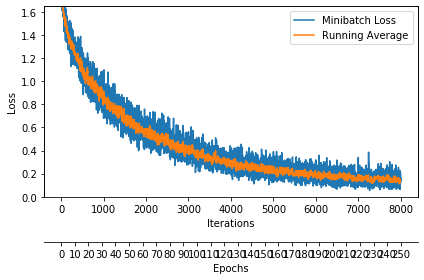

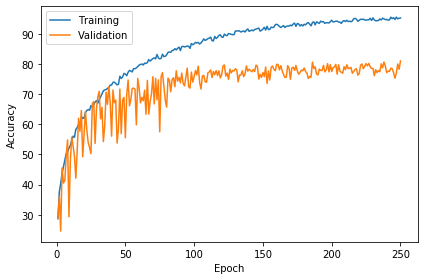

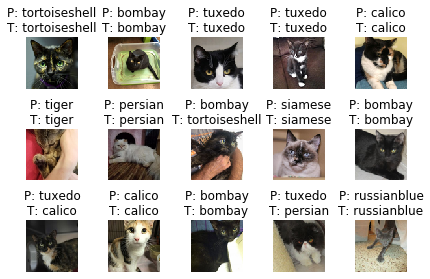

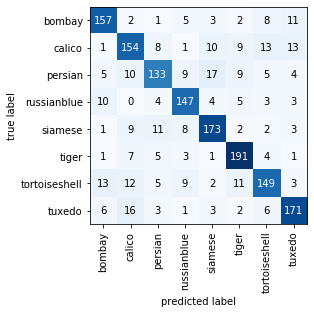

In [26]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))

plot_confusion_matrix(conf_matrix, class_names=cat_dict.values())
plt.show()